# Image segmentation

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-5.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Build a [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) (CNN for image segmentation) to predict a label for every pixel in an image from a self-driving dataset.

This type of image classification is similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows you to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class.

## Import libraries

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from keras import layers, Input, Model, losses

## Download the dataset

In [2]:
%%bash

gdown -q 1cEPZ0U0A7mb_-lDUB2FNboiIzo4j96Gi
unzip -q ./CameraRGB_CameraMask.zip
rm ./CameraRGB_CameraMask.zip

## Load the dataset

In [3]:
image_directory = "./data/CameraRGB/"
mask_directory = "./data/CameraMask/"
image_paths = [image_directory + file for file in sorted(os.listdir(image_directory)) if ".png" in file]
mask_paths = [mask_directory + file for file in sorted(os.listdir(mask_directory)) if ".png" in file]
train_image_paths, validation_image_paths = image_paths[:900], image_paths[900:]
train_mask_paths, validation_mask_paths = mask_paths[:900], mask_paths[900:]

def load_images_masks(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, (144, 192), method="nearest")
    image = tf.image.convert_image_dtype(image, "float32")

    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (144, 192), method="nearest")
    mask = tf.image.convert_image_dtype(mask, "uint8")

    return image, mask

train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths)).map(load_images_masks).batch(32)
validation_ds = tf.data.Dataset.from_tensor_slices((validation_image_paths, validation_mask_paths)).map(load_images_masks).batch(32)

## Visualize the dataset

In [4]:
frames = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for image_path, mask_path in zip(image_paths, mask_paths):
    image, mask = load_images_masks(image_path, mask_path)

    ax1.axis("off")
    ax1.set_title("Input image")
    frame1 = ax1.imshow(image, animated=True)

    ax2.axis("off")
    ax2.set_title("True mask")
    frame2 = ax2.imshow(mask, animated=True, cmap="Paired")

    plt.tight_layout()
    frames.append([frame1, frame2])

anim = animation.ArtistAnimation(fig, frames, interval=25, blit=True)
plt.close(fig)

anim.save('./portfolio-5-1.mp4', writer=animation.FFMpegWriter(fps=40))

In [5]:
%%html

<video controls>
    <source src="./portfolio-5-1.mp4" type="video/mp4">
</video>

## Create the U-Net model

U-Net uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.

In [6]:
#########
# Input #
#########
inputs = Input(shape=(144, 192, 3))

################
# Downsampling #
################

# Block 1
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
block_1 = x
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Block 2
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
block_2 = x
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Block 3
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
block_3 = x
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Block 4
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.Dropout(0.3)(x)
block_4 = x
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Block 5
x = layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.Dropout(0.3)(x)

##############
# Upsampling #
##############

# Block 1
x = layers.Conv2DTranspose(filters=256, kernel_size=3, strides=(2, 2), padding='same')(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(layers.concatenate([x, block_4]))
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

# Block 2
x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=(2, 2), padding='same')(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(layers.concatenate([x, block_3]))
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

# Block 3
x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding='same')(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(layers.concatenate([x, block_2]))
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

# Block 4
x = layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(layers.concatenate([x, block_1]))
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

##########
# Output #
##########
number_classes = 23
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
outputs = layers.Conv2D(filters=number_classes, kernel_size=1, padding='same')(x)
model = Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 144, 192, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 144, 192, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 144, 192, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 72, 96, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

## Compile the model

In [8]:
model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

## Fit the model

In [9]:
history = model.fit(train_ds, epochs=50, verbose=0, validation_data=validation_ds)

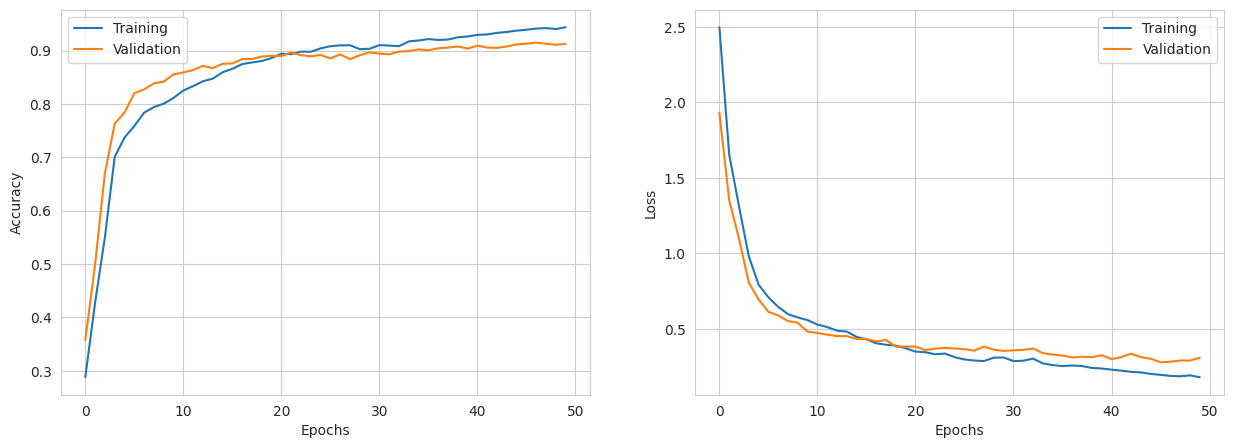

In [10]:
sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Training", "Validation"])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["Training", "Validation"])

plt.show()

## Evaluate the model

In [11]:
def predicted_mask(image, model):
    pred_mask = model.predict(image[tf.newaxis, ...], verbose=0)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    return pred_mask[0]

In [12]:
frames = []

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

for image_path, mask_path in zip(image_paths, mask_paths):
    image, mask = load_images_masks(image_path, mask_path)

    ax1.axis("off")
    ax1.set_title("Input image")
    frame1 = ax1.imshow(image, animated=True)

    ax2.axis("off")
    ax2.set_title("True mask")
    frame2 = ax2.imshow(mask, animated=True, cmap="Paired")

    ax3.axis("off")
    ax3.set_title("Predicted mask")
    frame3 = ax3.imshow(predicted_mask(image, model), animated=True, cmap="Paired")

    plt.tight_layout()
    frames.append([frame1, frame2, frame3])

anim = animation.ArtistAnimation(fig, frames, interval=25, blit=True)
plt.close(fig)

anim.save('./portfolio-5-2.mp4', writer=animation.FFMpegWriter(fps=40))

In [13]:
%%html

<video controls>
    <source src="./portfolio-5-2.mp4" type="video/mp4">
</video>

In [ ]:
!rm -rf ./data